In [ ]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

Firstly, we read the input (frequency change by years) abd put them in a list

In [23]:
# load Input data and normalize
dir = '../result/HumanN2Sweep_All.tsv'
def cal_frechg(input,sites):
    NA_df = pd.read_csv(input,sep='\t')
    DF_ls = []
    Mut_ls = []
    for i in sites:
        i_df = NA_df[NA_df['pos']==i]
        mut_set = list(set(i_df.mut))
        for mut in mut_set:
            df = i_df[i_df.mut==mut]
            df['change'] =df.freq-df.freq.shift(1)
            df = df.loc[:, ["year", "change"]]
            df.set_index("year",inplace=True)
            # set the date columns as index
            df.sort_index(inplace=True)
            df=df.replace(np.nan, 0)
            DF_ls.append(df)
            Mut_ls.append(mut)
    return DF_ls,Mut_ls
sites = [328,329,344,367,368,369,370]
df_ls,mut_ls = cal_frechg(dir,sites)

print(len(df_ls))

21


<ipython-input-23-31f068b8b88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] =df.freq-df.freq.shift(1)
<ipython-input-23-31f068b8b88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change'] =df.freq-df.freq.shift(1)
<ipython-input-23-31f068b8b88e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

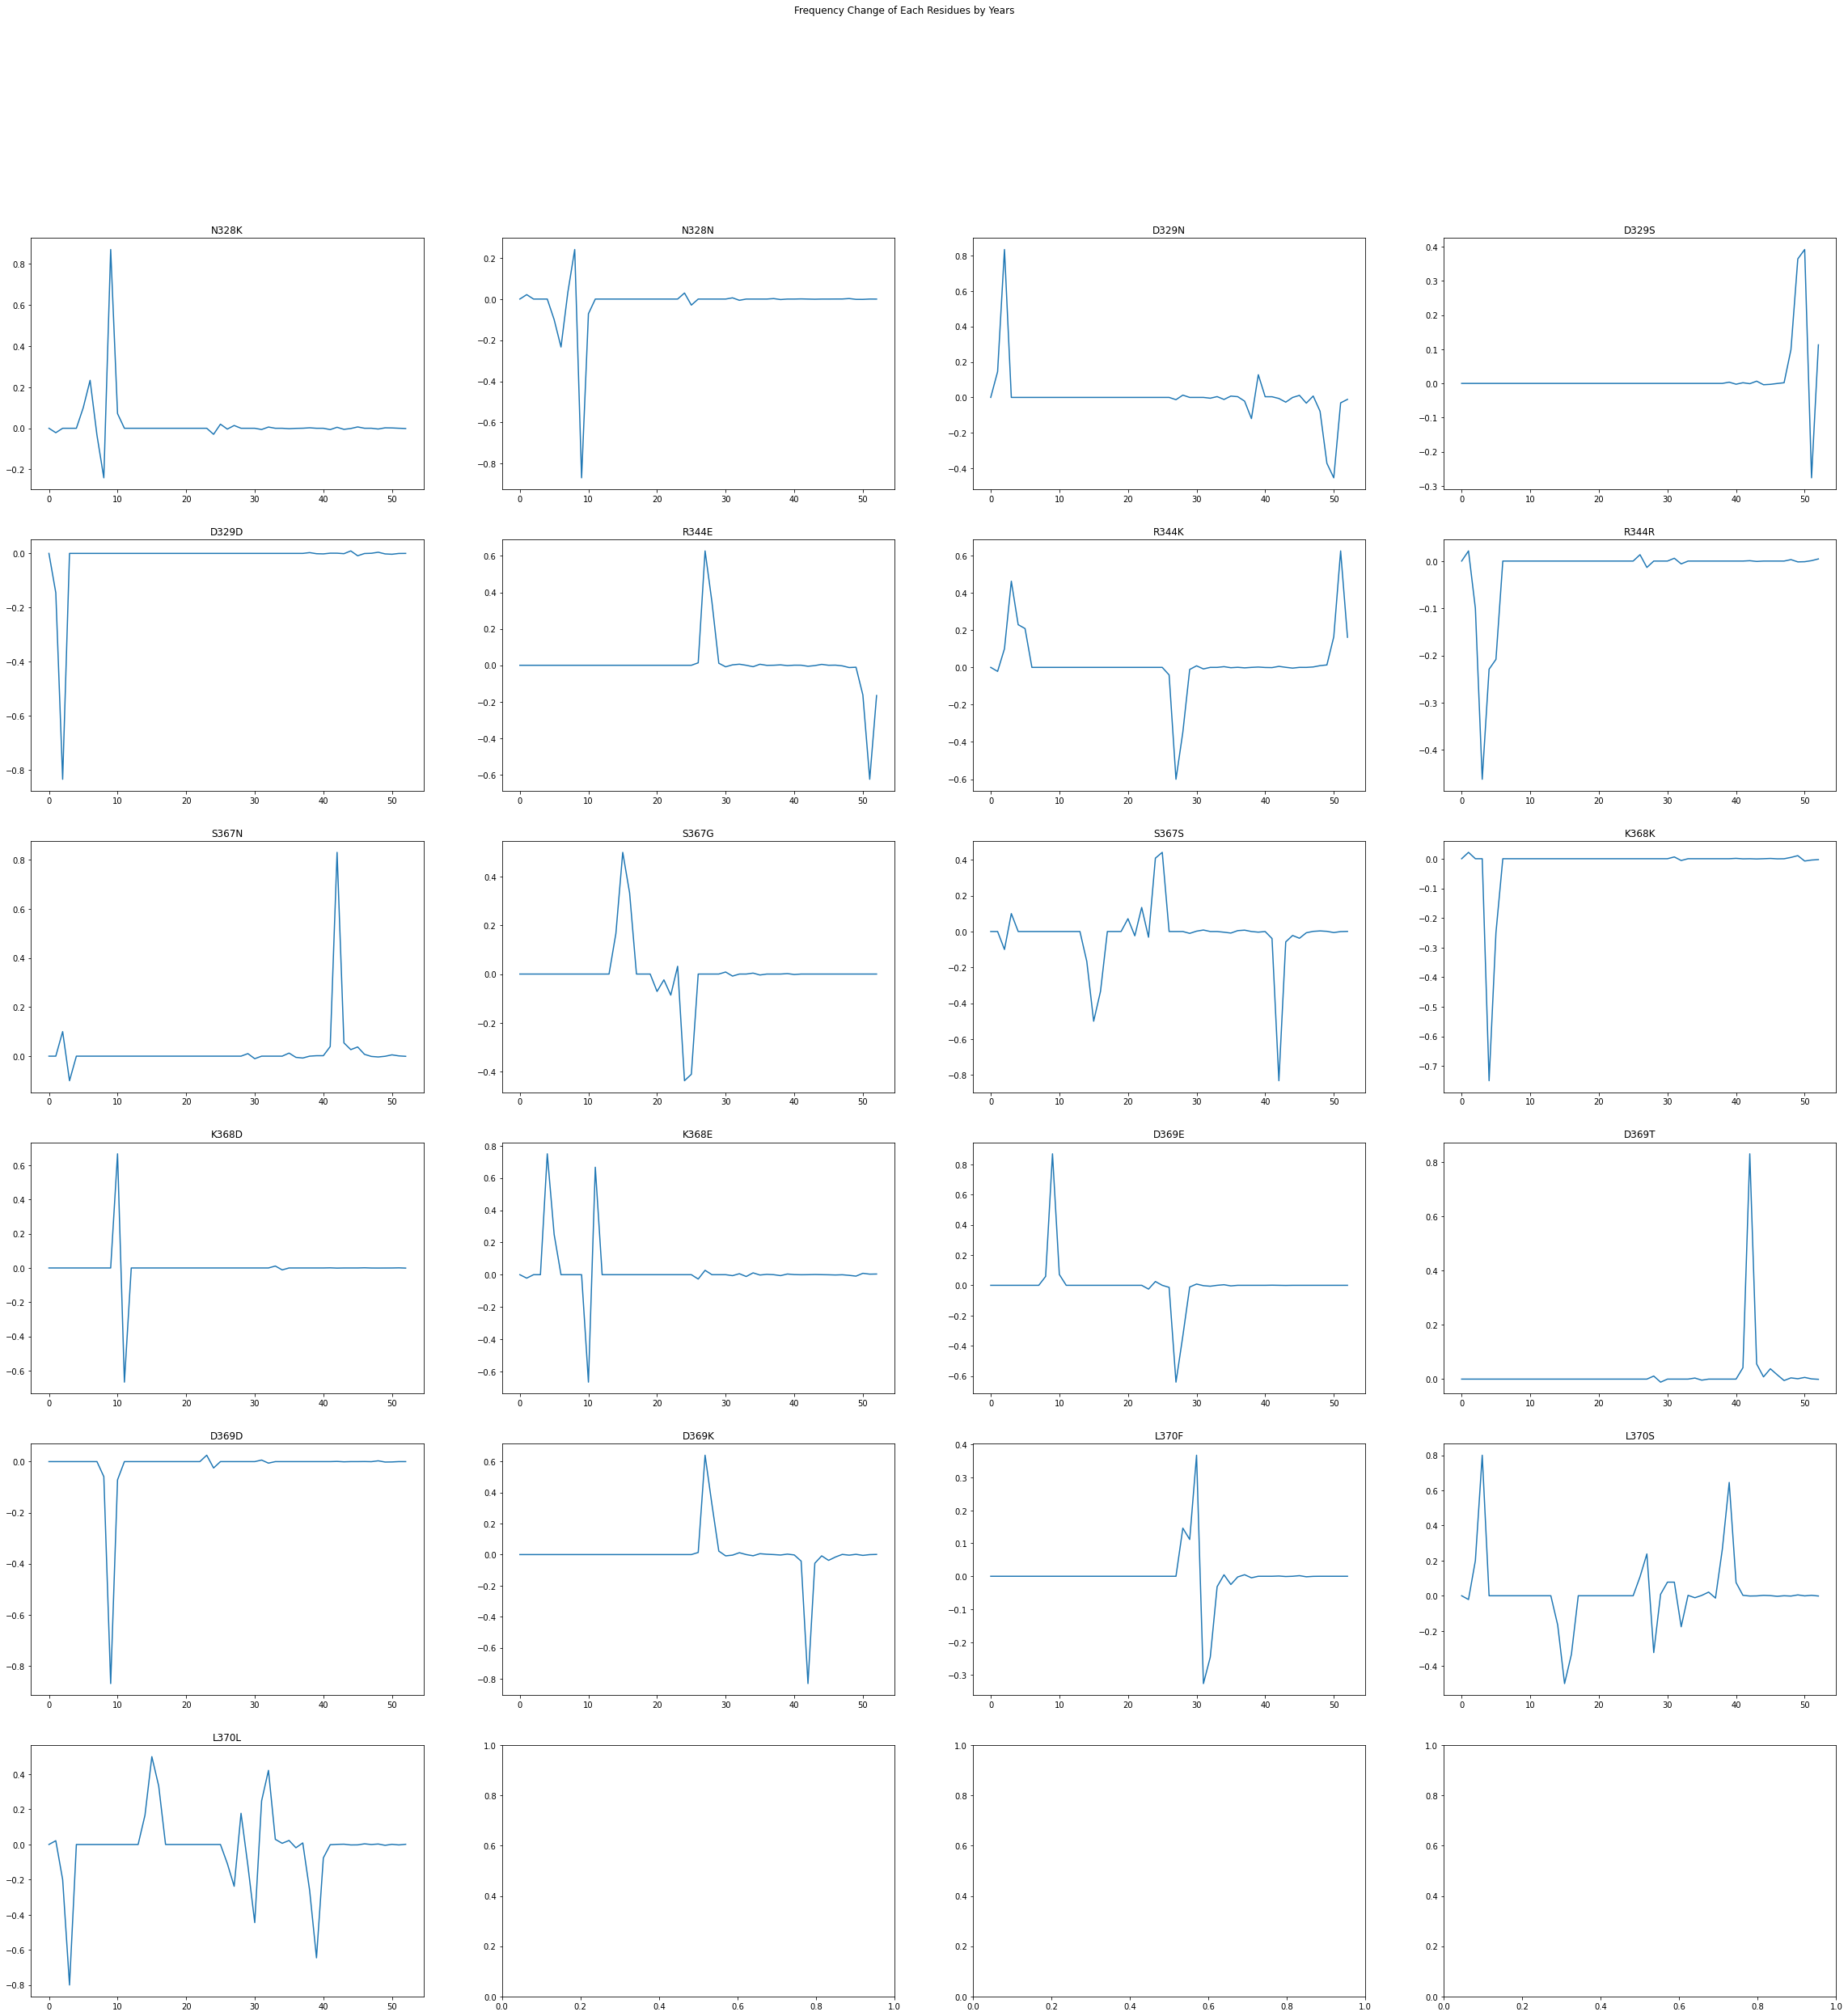

In [25]:
fig, axs = plt.subplots(6,4,figsize=(40,40))
fig.suptitle('Frequency Change of Each Residues by Years')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(df_ls): # pass the others that we can't fill
            continue
        axs[i, j].plot(df_ls[i*4+j].values)
        axs[i, j].set_title(mut_ls[i*4+j])
plt.show()

In [26]:
df_lengths = {len(mut_df) for mut_df in df_ls}
print(df_lengths)

{53}


In [27]:
#normailze data
for i in range(len(df_ls)):
    scaler = MinMaxScaler()
    df_ls[i] = MinMaxScaler().fit_transform(df_ls[i])
    df_ls[i]= df_ls[i].reshape(len(df_ls[i]))
print("max: "+str(max(df_ls[0]))+"\tmin: "+str(min(df_ls[0])))
print(df_ls[0][:5])

max: 1.0	min: 0.0
[0.21709531 0.19773722 0.21709531 0.21709531 0.21709531]


In [28]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_ls))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(df_ls[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(df_ls)
som.train(df_ls, 50000)

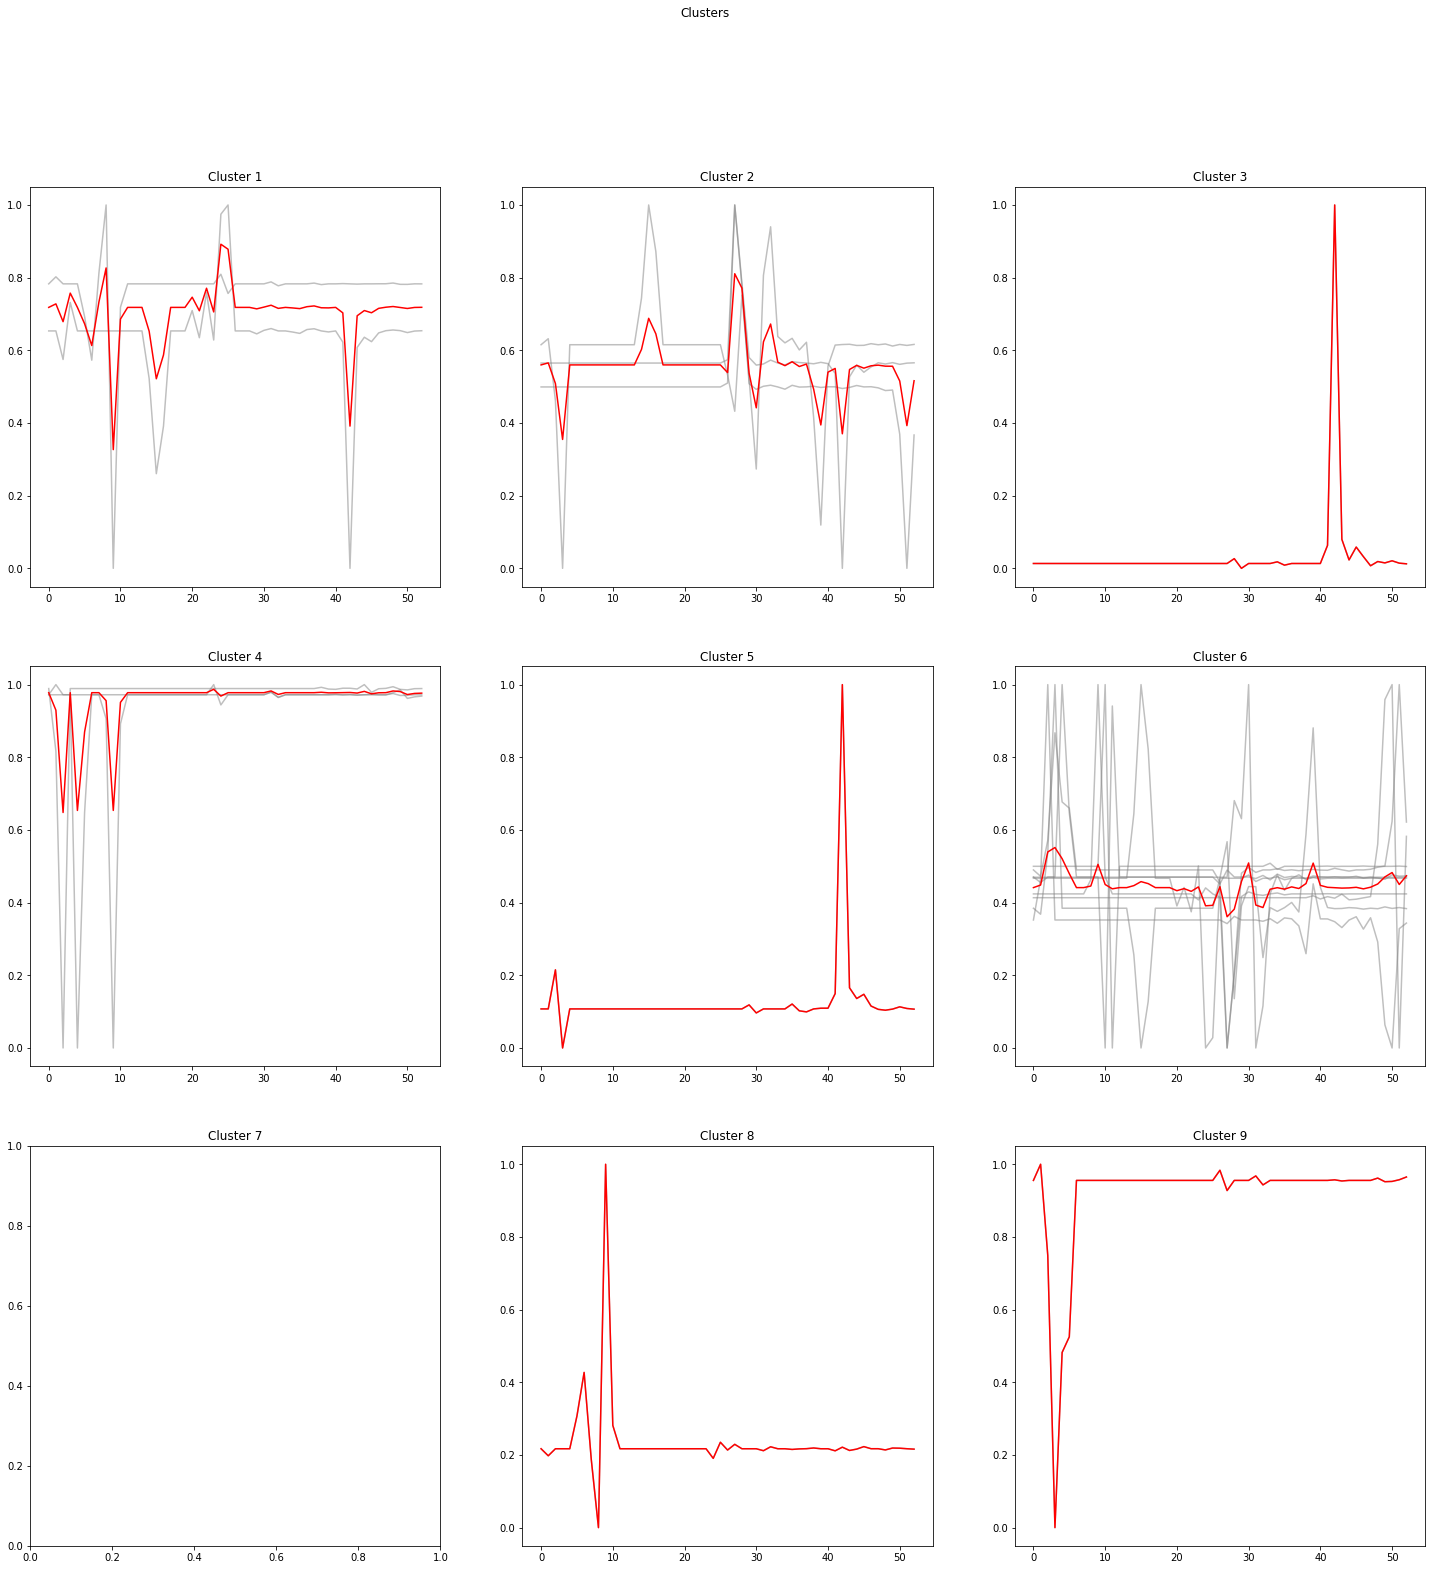

In [29]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
win_map = som.win_map(df_ls)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

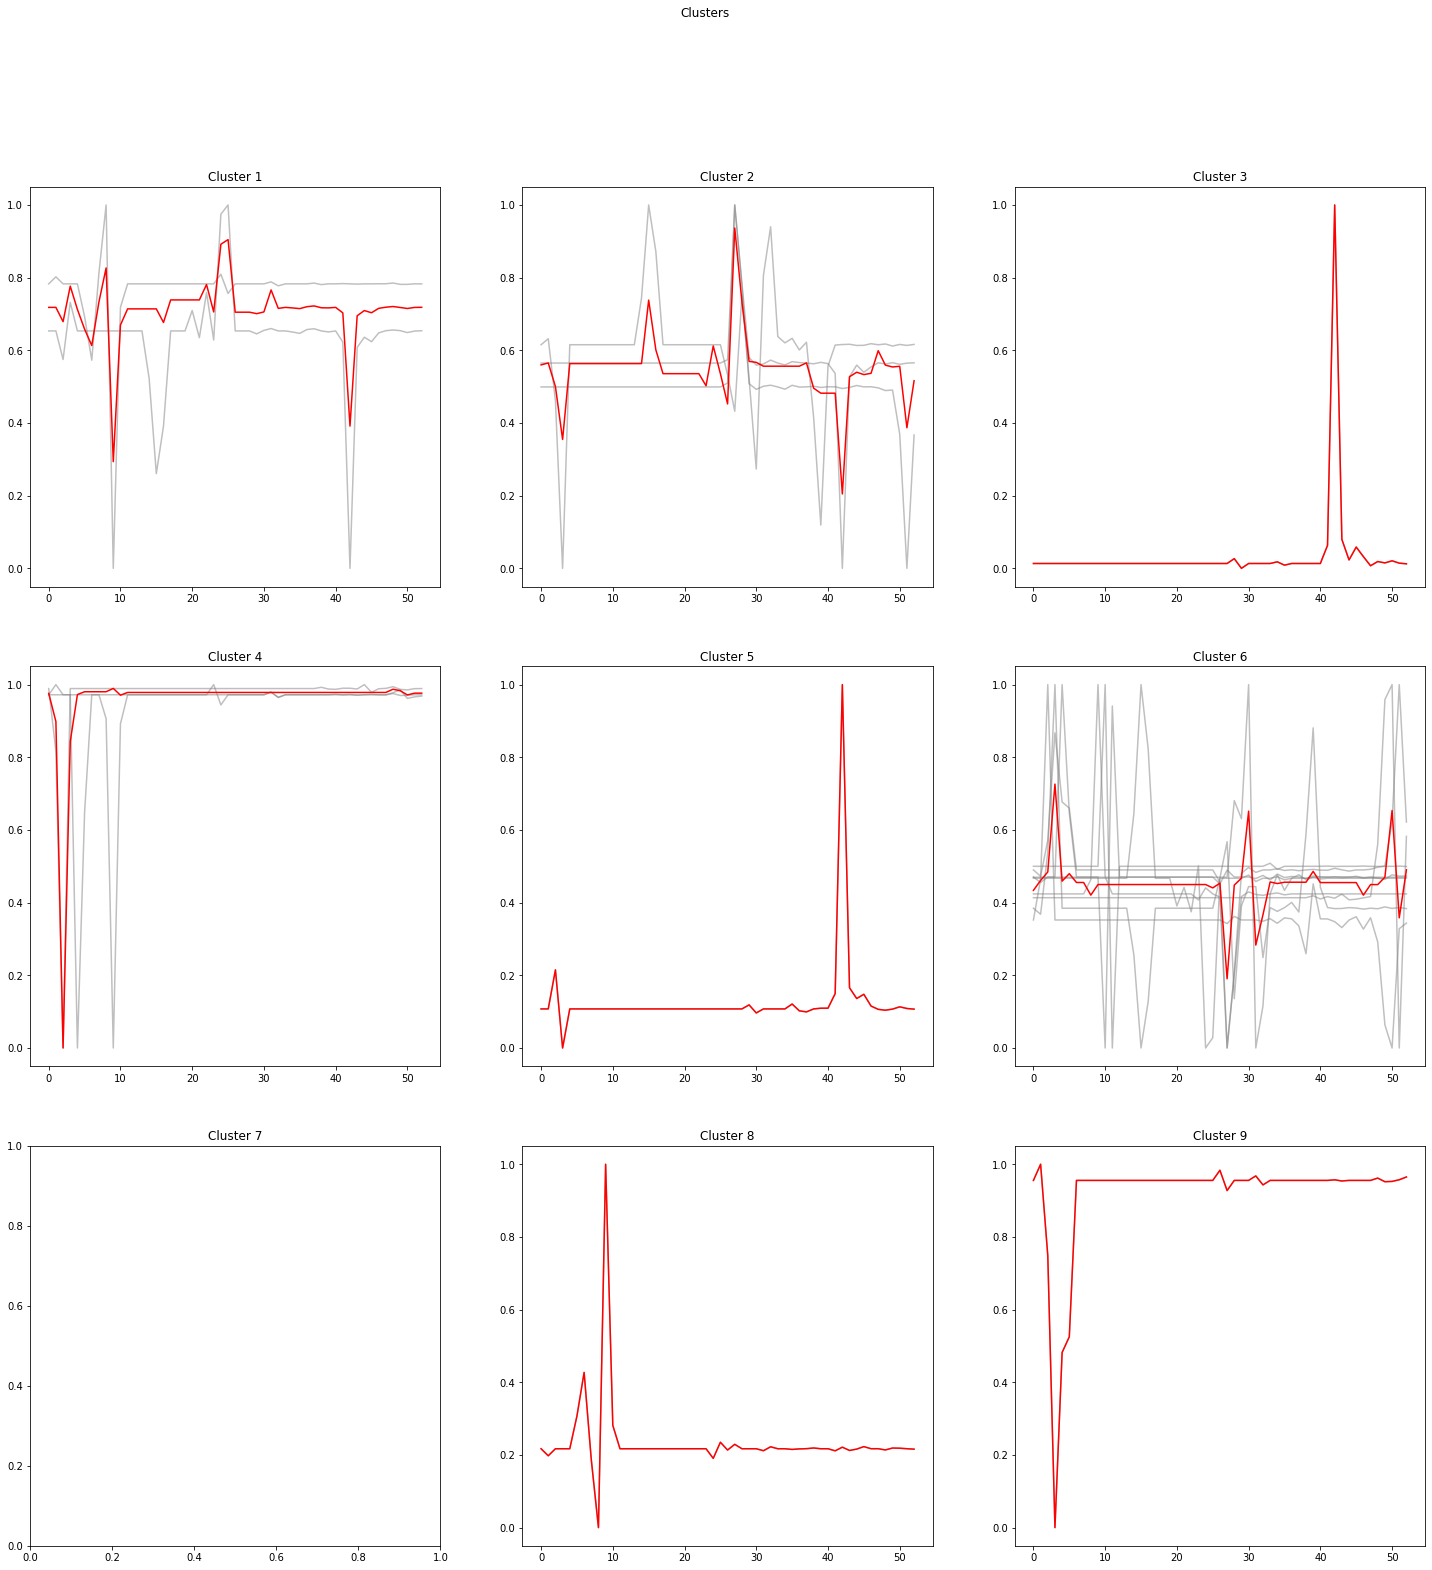

In [30]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
win_map = som.win_map(df_ls)

plot_som_series_dba_center(som_x, som_y, win_map)

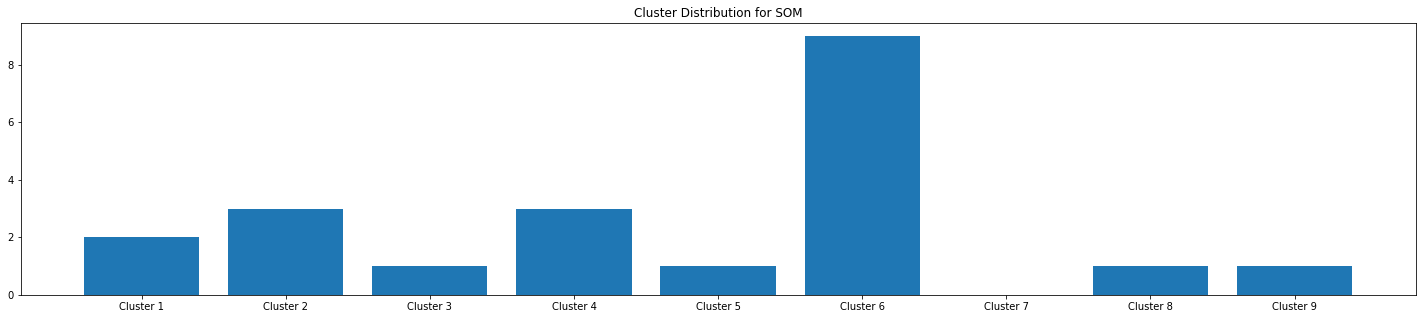

In [31]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [10]:
cluster_map = []
for idx in range(len(df_ls)):
    winner_node = som.winner(df_ls[idx])
    cluster_map.append((mut_ls[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

resi_cluster_df = pd.DataFrame(cluster_map,columns=["Residues","Cluster"]).sort_values(by="Cluster").set_index("Residues")
resi_cluster_df.to_csv('../result/resi_cluster.csv')

In [32]:
cluster_count = math.ceil(math.sqrt(len(df_ls))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(df_ls)

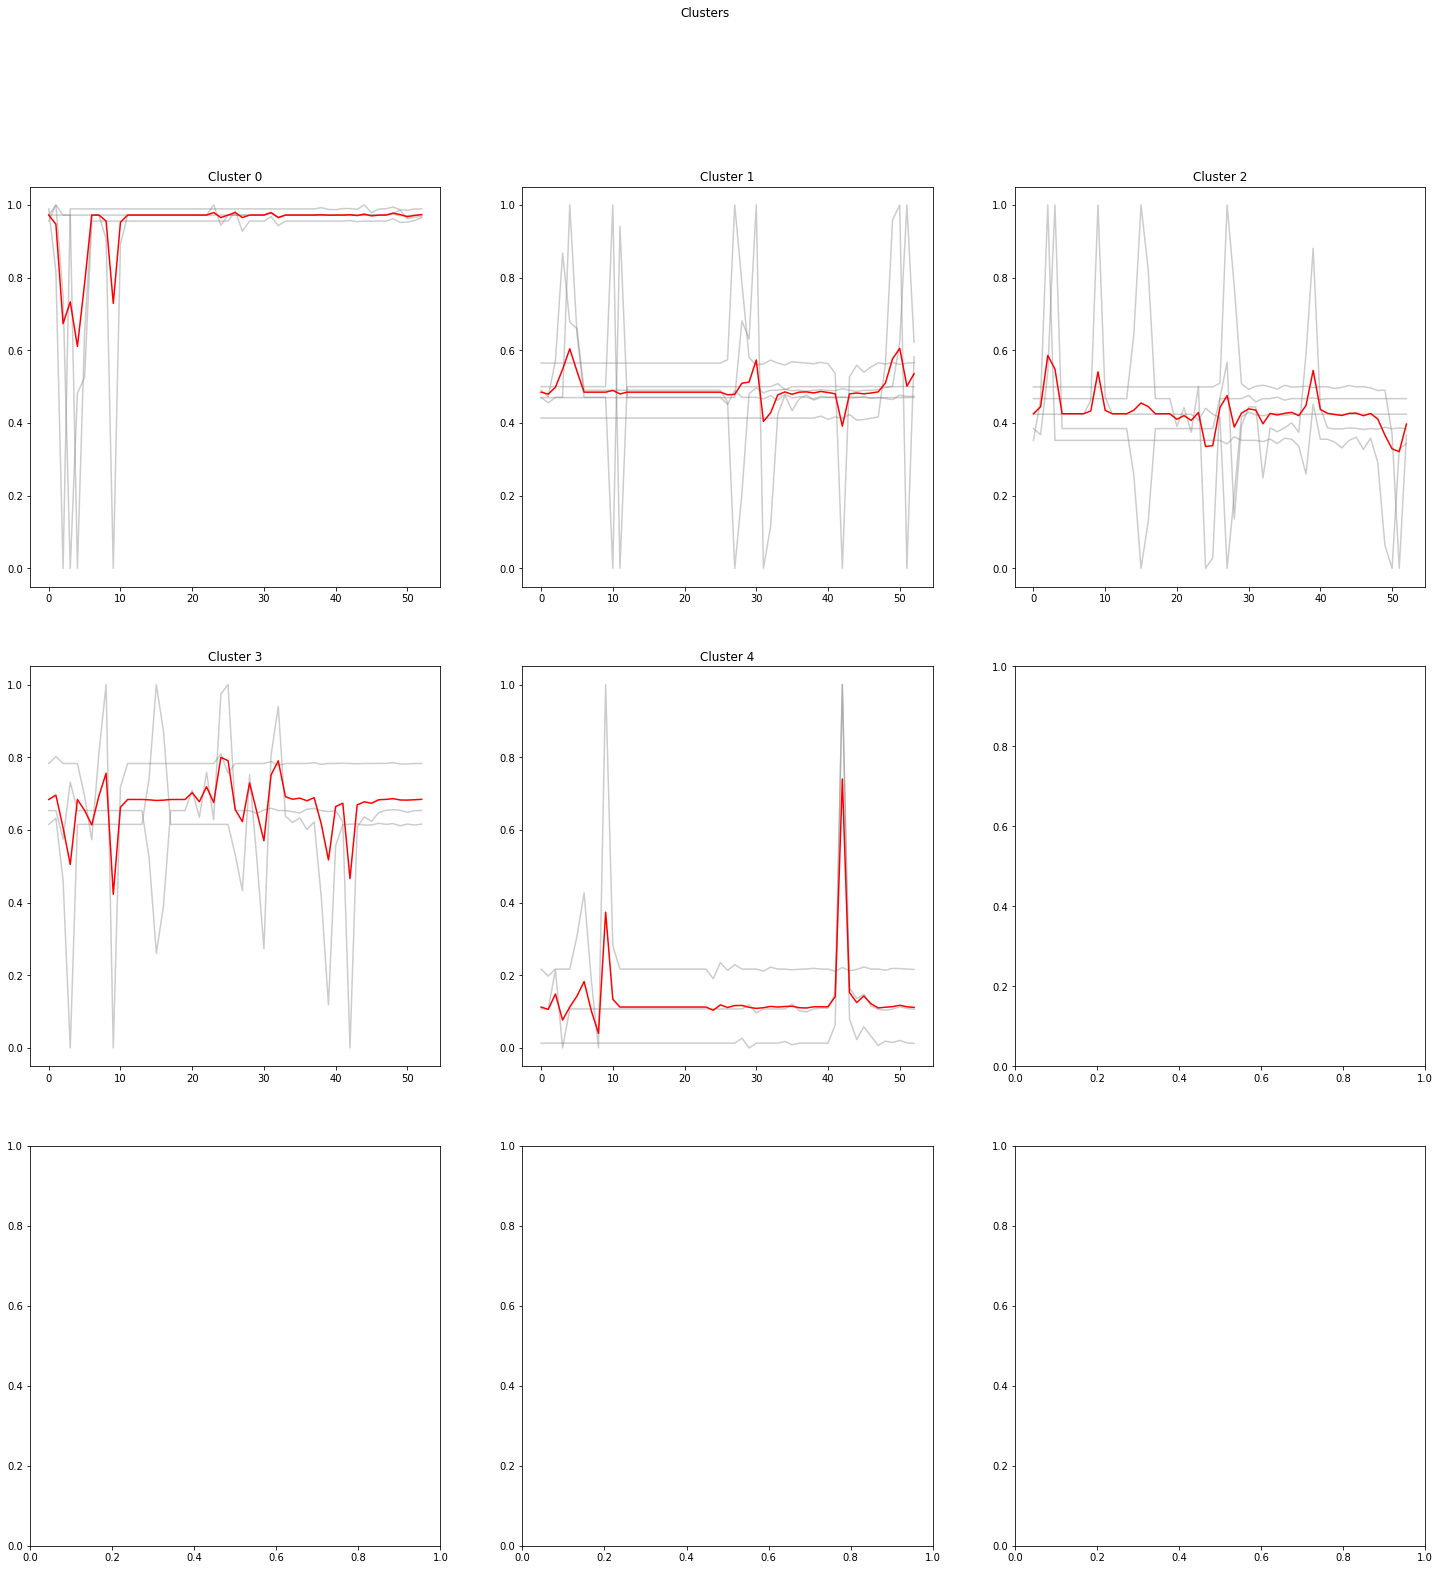

In [34]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_ls[i],c="gray",alpha=0.4)
                cluster.append(df_ls[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

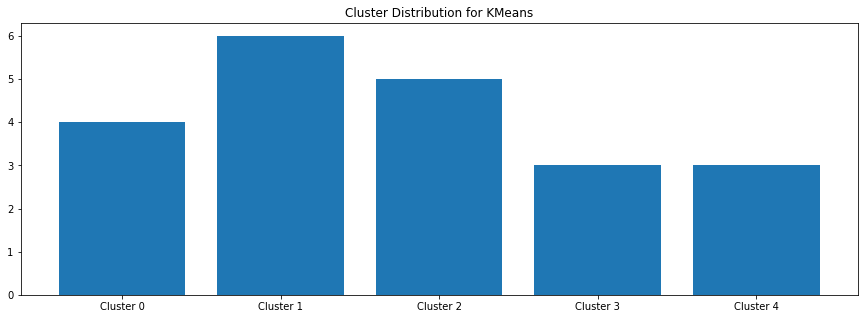

In [35]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [36]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
resi_cluster_k = pd.DataFrame(zip(mut_ls,fancy_names_for_labels),columns=["Residues","Cluster"]).sort_values(by="Cluster").set_index("Residues")
resi_cluster_k.to_csv('../result/resi_k_cluster.csv')